In [4]:
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Configuração para exibir imagens no Jupyter
%matplotlib inline

In [5]:
import kagglehub

# Download latest version
path_dados = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path_dados)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [14]:
import os

# Lista os arquivos e pastas dentro do caminho do dataset
for root, dirs, files in os.walk(path_dados):
    print(root)
    for name in files:
        # Imprime apenas os primeiros 5 arquivos
        if files.index(name) < 5:
            print(os.path.join(root, name))

/kaggle/input/brain-tumor-mri-dataset
/kaggle/input/brain-tumor-mri-dataset/Training
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0482.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0641.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0592.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0711.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0746.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma
/kaggle/input/brain-tumor-mri-datas

In [10]:
image_folder = Path(path_dados) / 'Training' / 'glioma'
image_name = 'Tr-gl_0954.jpg'
image_path = image_folder / image_name

try:
    # Carregar a imagem em tons de cinzento (modo 'L')
    original_image = Image.open(image_path).convert('L')
    # para manipulação direta de pixels
    original_array = np.array(original_image, dtype=np.uint8)

    print(f"Imagem carregada: {image_name}")
    print(f"Dimensões: {original_array.shape}")

except FileNotFoundError:
    print(f"ERRO: Não encontrado em '{image_path}'")
    print("Por favor, verifique se o caminho 'path_dados' está correto.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar a imagem: {e}")

Imagem carregada: Tr-gl_0954.jpg
Dimensões: (512, 512)


In [11]:
# FUNÇÃO: ADICIONAR RUÍDO SAL E PIMENTA

def adicionar_ruido_sal_pimenta(imagem_array, amount=0.05):
    """
    Adiciona ruído sal e pimenta manipulando diretamente os pixels.
    'amount' define a proporção total de pixels afetados.
    """
    # Cópia para evitar de modificar o array original
    noisy_array = np.copy(imagem_array)
    altura, largura = noisy_array.shape

    # Calcular o número total de pixels a serem afetados
    num_pixels_ruidosos = int(amount * altura * largura)

    # Coordenadas aleatórias únicas para os pixels serem alterados
    y_coords = np.random.randint(0, altura, num_pixels_ruidosos)
    x_coords = np.random.randint(0, largura, num_pixels_ruidosos)

    # Pimenta (0)
    num_pimenta = num_pixels_ruidosos // 2
    noisy_array[y_coords[:num_pimenta], x_coords[:num_pimenta]] = 0

    # Sal (255)
    num_sal = num_pixels_ruidosos - num_pimenta
    noisy_array[y_coords[num_pimenta:], x_coords[num_pimenta:]] = 255

    return noisy_array

In [12]:
# FUNÇÃO: APLICAR FILTRO DE MEDIANA (SUAVIZAÇÃO)

def aplicar_filtro_mediana(imagem_array, kernel_size=3):
    """
    Aplica o filtro de mediana (suavização) por manipulação direta do kernel.
    """
    filtered_array = np.copy(imagem_array)
    altura, largura = imagem_array.shape
    margem = kernel_size // 2

    # Itera sobre todos os pixels, exceto as bordas (margem)
    for y in range(margem, altura - margem):
        for x in range(margem, largura - margem):

            # 1. Extrair a janela (kernel_size x kernel_size) de pixels vizinhos.
            # Manipulação direta do kernel.
            window = imagem_array[
                y - margem : y + margem + 1,
                x - margem : x + margem + 1
            ]

            # 2. Achatar a matriz da janela para obter uma lista de valores de pixels
            vizinhos = window.flatten()

            # 3. Ordena e pega o valor central
            vizinhos_ordenados = np.sort(vizinhos)
            mediana = vizinhos_ordenados[len(vizinhos_ordenados) // 2]

            # 4. Atribuir o valor da mediana ao pixel central na imagem filtrada
            filtered_array[y, x] = mediana

    return filtered_array

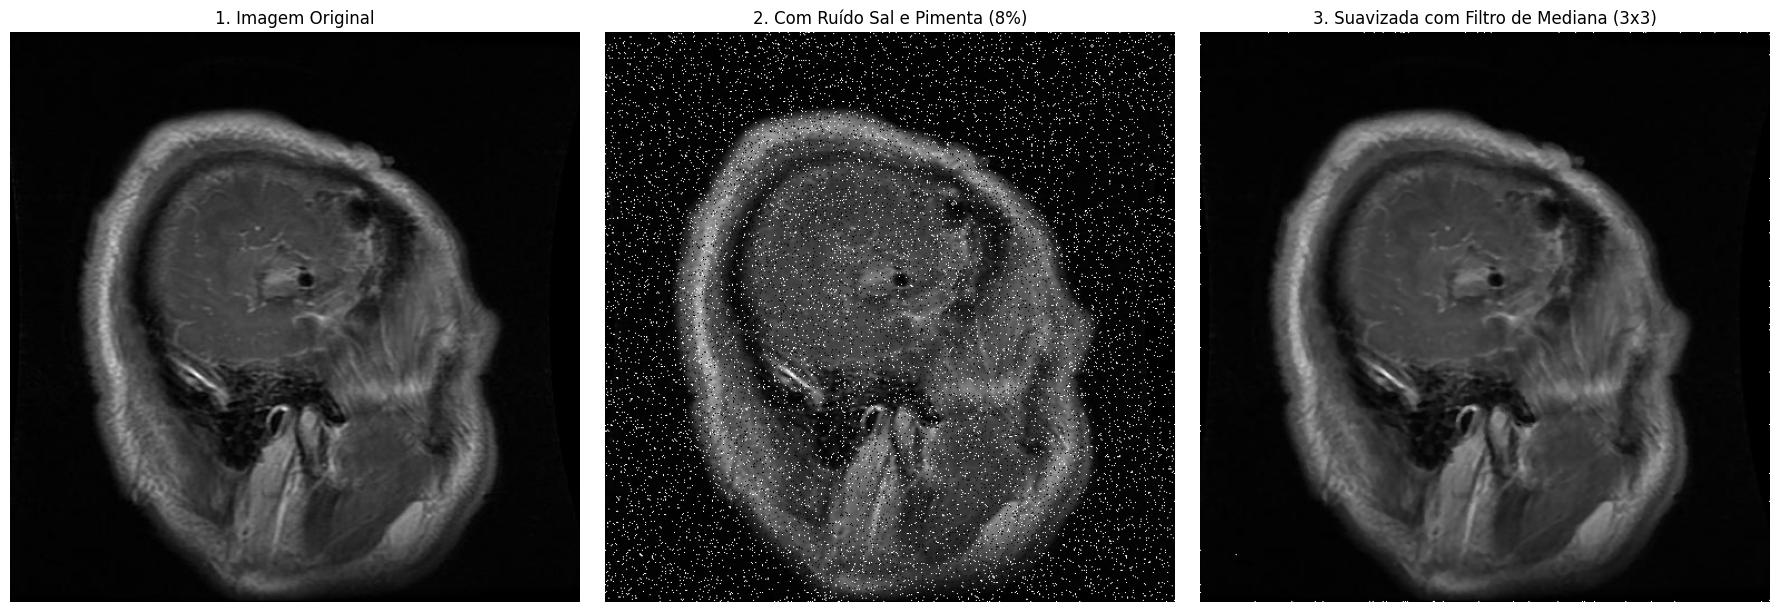

In [13]:
if 'original_array' in locals():
    # Parâmetros
    NOISE_AMOUNT = 0.08  # 8% de pixels ruidosos
    FILTER_SIZE = 3      # Janela do filtro de 3x3

    # Processamento
    noisy_array = adicionar_ruido_sal_pimenta(original_array, amount=NOISE_AMOUNT)
    filtered_array = aplicar_filtro_mediana(noisy_array, kernel_size=FILTER_SIZE)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original
    axes[0].imshow(original_array, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('1. Imagem Original')
    axes[0].axis('off')

    # Ruído Sal e Pimenta
    axes[1].imshow(noisy_array, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f'2. Com Ruído Sal e Pimenta ({NOISE_AMOUNT*100:.0f}%)')
    axes[1].axis('off')

    # Filtro de Mediana
    axes[2].imshow(filtered_array, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f'3. Suavizada com Filtro de Mediana ({FILTER_SIZE}x{FILTER_SIZE})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()